In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader


# model used for MC-dropout
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.dropout3 = nn.Dropout(0.1)
        self.fc4 = nn.Linear(hidden_size3, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.sigmoid(self.fc4(x))  # Sigmoid activation for binary classification
        return x

In [2]:
# function that calculates the standard deviation, which is an estimate for uncertainty
def calculate_std(model, features):
    num_samples = 100
    mc_predictions = []
    with torch.no_grad():
        model.train()
        mc_predictions_batch = torch.zeros(num_samples, features.shape[0], 12) # 12 AU classes
        for i in range(num_samples):
            y_pred = model(features)
            # print(y_pred_val.shape)
            mc_predictions_batch[i] = y_pred.squeeze()
        mc_predictions.append(mc_predictions_batch)
    mc_predictions = torch.concat(mc_predictions, dim=1)
    
    std_predictions = mc_predictions.std(dim=0)
    std_predictions_mean = std_predictions.mean(dim=1)
    std_predictions_mean = std_predictions_mean.squeeze()
    return std_predictions_mean

In [3]:
import cv2
import numpy as np
import os
import torch
import timm

# fuction that takes in a video, and return its features
def generate_features(video_path):
    device = "cuda"
    
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model = model.to(device)
    model.eval()
    
    def preprocess_frame(frame):
        frame = cv2.resize(frame, (224, 224), interpolation=cv2.INTER_AREA)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = torch.tensor(frame / 255.0, dtype=torch.float32)
        frame = (frame - torch.tensor([0.485, 0.456, 0.406])) / torch.tensor([0.229, 0.224, 0.225])
        frame = frame.permute(2, 0, 1).unsqueeze(0)  # Reshape to [1, 3, 224, 224]
        return frame
    
    cap = cv2.VideoCapture(video_path)
    frame_index = 0
    all_features=[]
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            # Preprocess the frame
            input_tensor = preprocess_frame(frame)
    
            input_tensor = input_tensor.to(device)
    
            # Extract features
            with torch.no_grad():
                features = model.forward_features(input_tensor)
            
            all_features.append(features.cpu().numpy())
            # Save features to a file
            frame_index += 1
        else:
            break
    cap.release()
    features = torch.tensor(np.array(all_features))
    features = features.mean(axis=2, keepdims=False)
    features = features.permute(1, 0, 2)
    return features

/home1/ruijiefe/.conda/envs/ua/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
video_path = "./video_blurred/53-30-360x480.mp4"
original_video_path = "./video_bipeng/53-30-360x480.mp4"
video_features = generate_features(video_path)
original_video_features = generate_features(original_video_path)

In [5]:
video_features.shape

torch.Size([1, 1053, 768])

In [6]:
original_video_features.shape

torch.Size([1, 1052, 768])

In [8]:
device = "cuda"
video_features = video_features.to(device)
original_video_features = original_video_features.to(device)

In [9]:
video_model = torch.load("./best_model_video.pt") # pre-trained video model using the previously defined model
video_features = video_features.squeeze()
video_std = calculate_std(video_model, video_features)
original_video_features = original_video_features.squeeze()
original_video_std = calculate_std(video_model, original_video_features)

In [15]:
# The length of the video is 35.07s.
# The two start time-steps of blurring are 3.035s and 29.144s.
# The blur durations are 1 second.
# The fps of the video is 30.
print(f"Therefore, the start-frames for the blurring are about {int(3.035 * 30)} and {int(29.144 * 30)}")

Therefore, the start-frames for the blurring are about 91 and 874


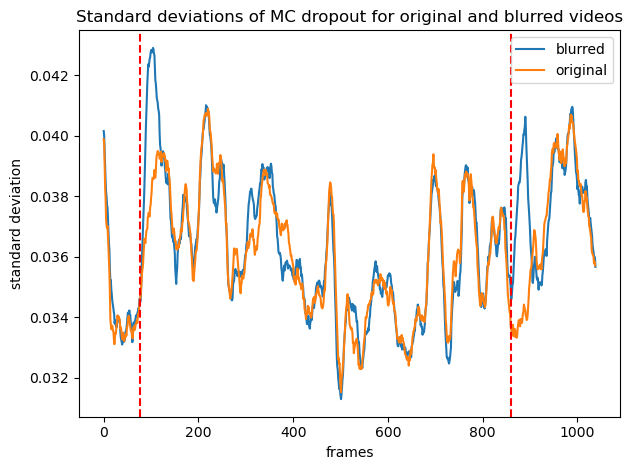

In [18]:
import matplotlib.pyplot as plt

window_size = 15

data = video_std.cpu().numpy()
smoothed_data = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
plt.plot(smoothed_data, label="blurred")

original_data = original_video_std.cpu().numpy()
smoothed_original_data = np.convolve(original_data, np.ones(window_size)/window_size, mode='valid')
plt.plot(smoothed_original_data, label="original")
plt.axvline(x=91 - window_size, color='red', linestyle='--')
plt.axvline(x=874 - window_size, color='red', linestyle='--')
plt.title("Standard deviations of MC dropout for original and blurred videos")
plt.xlabel("frames")
plt.ylabel("standard deviation")
plt.legend()
plt.tight_layout()

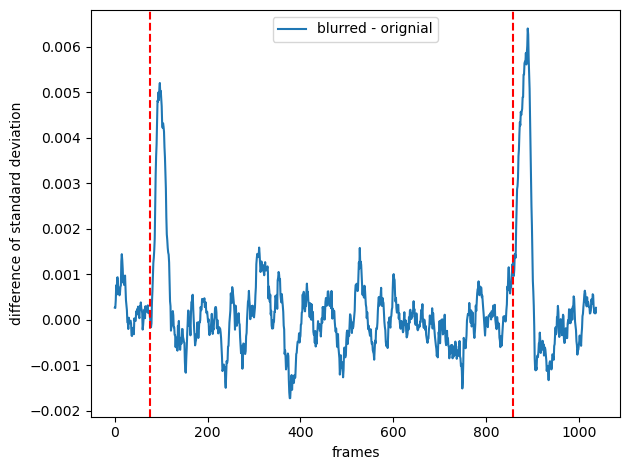

In [19]:
min_len = min(len(smoothed_data), len(smoothed_original_data))
plt.plot(smoothed_data[:min_len] - smoothed_original_data[:min_len], label="blurred - orignial")
plt.axvline(x=91 - window_size, color='red', linestyle='--')
plt.axvline(x=874 - window_size, color='red', linestyle='--')
plt.xlabel("frames")
plt.ylabel("difference of standard deviation")
plt.legend()
plt.tight_layout()